# Calculating and Analyzing Climate Indices Using SST Anomalies

In this exercise, you’ll calculate SST anomaly-based indices like the Dipole Mode Index (DMI), Niño 3.4, and the Tropical Northern Atlantic (TNA) index. The TNA is a climate variability index tracking SST anomalies in the eastern tropical North Atlantic, which influence precipitation in South America. These indices are essential for understanding climate patterns. You’ll adjust existing functions to analyze climate events through composites. You'll also include latitude weighting for accurate regional SST representation.

**<p style="color:royalblue;">The effect of latitudinal weighting is minimal in our case, as the spatial regions we average are close to the equator. This method becomes more important when averaging globally or when anomalies within the box vary significantly from grid cell to grid cell. However, for consistency, it is good practice to apply it in all cases.</p>**

## Tasks
The code cell below contains the function you need to modify to include calculations for the Niño 3.4 and TNA indices. Use the DMI calculation as a reference, as it is already implemented in the code. Your task is to extend this function to calculate the Niño 3.4 and TNA indices, incorporating latitude weighting for accuracy.


### 1. Calculate Indices
- **Niño 3.4**: Copy code from [`enso_functions.py`](../Session2_DataHandling/enso_functions.py), add latitude weighting, and verify results.
- **TNA**: Use [NOAA's bounding box for TNA](https://stateoftheocean.osmc.noaa.gov/sur/atl/tna.php). Calculate a 3-month rolling mean and define positive events for June-August with values >0.4°C.
- Reference the DMI calculation to see how to implement latitude weighting.



### 2. Define Positive and Negative Events
- Set threshold-based criteria to define events for each index.

### 3. Generate Composites
- Use provided functions to visualize SST anomaly composites for positive and negative events.




In [2]:
import numpy as np
import matplotlib.pyplot as plt

import xarray as xr
from scipy.signal import detrend

def calculate_index(sst_anom_detrended, index_name):
    """
    Generalized function to calculate climate indices based on SST anomalies and specified region(s).
    """

    # Calculate latitude weights
    latitudes = sst_anom_detrended['lat']
    weights = np.cos(np.deg2rad(latitudes)).where(~sst_anom_detrended[0].isnull()).fillna(0)
    ## test without lat weighting - effect negligible for near equator boxes
    #weights = xr.DataArray(1, coords=sst_anom_detrended[0].coords, dims=sst_anom_detrended[0].dims)
    #weights = weights.where(~sst_anom_detrended[0].isnull()).fillna(0)

    

    if index_name.lower() == 'dmi':
        # Define regions for DMI (IOD Index): Western and Eastern Indian Ocean regions
        region1 = sst_anom_detrended.sel(lat=slice(10, -10), lon=slice(50, 70))
        region2 = sst_anom_detrended.sel(lat=slice(0, -10), lon=slice(90, 110))
        # Apply latitude weights and calculate the weighted mean for both regions
        weighted_region1 = (region1.weighted(weights)).mean(dim=['lat', 'lon'])
        weighted_region2 = (region2.weighted(weights)).mean(dim=['lat', 'lon'])
        # or 
        #weighted_region1 = (region1 * weights).mean(dim=['lat', 'lon'])
        #weighted_region2 = (region2 * weights).mean(dim=['lat', 'lon'])
        index = (weighted_region1 - weighted_region2).rolling(time=3, center=True).mean()

    elif index_name.lower() == 'nino3.4':
        # Define the Niño3.4 region (5°S–5°N, 170°W–120°W)
        sst_anom_region = sst_anom_detrended.sel(lat=slice(5, -5), lon=slice(190, 240))
        # Apply latitude weights and calculate the weighted mean
        index = (sst_anom_region.weighted(weights)).mean(dim=('lon', 'lat')).rolling(time=5, center=True).mean() 



    elif index_name.lower() == 'tna':
        # Define the TNA region (5°N–25°N, 55°W–15°W) -> 360-55, 360-15
        sst_anom_region = sst_anom_detrended.sel(lat=slice(25, 5), lon=slice(305, 345))
        # Apply latitude weights and calculate the weighted mean
        index = (sst_anom_region.weighted(weights)).mean(dim=('lon', 'lat')).rolling(time=3, center=True).mean() 

    # maybe additional elif statements for other indices like PDO, AMO here...

    else:
        raise ValueError(f"Index '{index_name}' not recognized.")

    return index

def calculate_composites(anom_detrended, index, index_name):
    """
    Calculate composites for positive and negative events based on the given index and climate pattern.
    """
    if index_name.lower() == 'dmi':
        # Define criteria for positive and negative IOD events (DMI)´
        # periods when the dmi exceeds a threshold of 0.4 °C for 3 consecutive month in a timeframe from June to November
        positive_events = ((index > 0.4).astype('b').rolling(time=3, center=True).sum() >= 3) & index['time.month'].isin([6, 7, 8, 9, 10, 11])
       
        negative_events = ((index < -0.4).astype('b').rolling(time=3, center=True).sum() >= 3) & index['time.month'].isin([6, 7, 8, 9, 10, 11])


    elif index_name.lower() == 'nino3.4':
        # Define criteria for El Niño and La Niña events
        # periods when nino3.4 exceeds 0.4 °C for 6 consecutive month 
        positive_events = ((index > 0.4).astype('b').rolling(time=6, center=True).sum() >= 6)
        negative_events = ((index < -0.4).astype('b').rolling(time=6, center=True).sum() >= 6)


    elif index_name.lower() == 'tna':
        # Define criteria for positive and negative TNA events in JJA (June, July, August)
        # periods when the dmi exceeds a threshold of 0.4 °C for 3 consecutive month from June to August
        positive_events = ((index > 0.4).astype('b').rolling(time=3, center=True).sum() >= 3) & index['time.month'].isin([6, 7, 8])
        negative_events = ((index < -0.4).astype('b').rolling(time=3, center=True).sum() >= 3) & index['time.month'].isin([6, 7, 8])

    # Maybe add criteria for other indices

    else:
        raise ValueError(f"Index '{index_name}' not recognized.")

    # Calculate the average anomaly during positive and negative events (this is the same for all indeces, therefore outside of the if-else block)
    anom_positive = anom_detrended.where(positive_events).mean(dim='time')
    anom_negative = anom_detrended.where(negative_events).mean(dim='time')

    return anom_positive, anom_negative

def plot_composites(anom_positive, anom_negative, vmin=-1.5, vmax=1.5, label='°C', variable='SST', index_name='Index', 
                    lon_range=None, lat_range=None):
    """
    Plot composites for positive and negative events based on the climate index provided, 
    with an option to focus on a specific region.
    
    Parameters:
    - anom_positive, anom_negative: xarray DataArrays for positive and negative anomalies
    - vmin, vmax: float, value range for color scale
    - label: str, colorbar label
    - variable: str, variable name to display in titles
    - index_name: str, index name to display in titles
    - lon_range: tuple of floats, (min_lon, max_lon) for longitude slicing
    - lat_range: tuple of floats, (min_lat, max_lat) for latitude slicing
    """
    # Slice the data for the specified region, if provided
    if lon_range:
        anom_positive = anom_positive.sel(lon=slice(lon_range[0], lon_range[1]))
        anom_negative = anom_negative.sel(lon=slice(lon_range[0], lon_range[1]))
    if lat_range:
        anom_positive = anom_positive.sel(lat=slice(lat_range[0], lat_range[1]))
        anom_negative = anom_negative.sel(lat=slice(lat_range[0], lat_range[1]))

    # Plotting
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), sharey=True)

    anom_positive.plot(ax=axes[0], cbar_kwargs={'label': label}, vmin=vmin, vmax=vmax, cmap='RdBu_r')
    axes[0].set_title(f'{variable} Anomaly - Positive {index_name} Event')

    anom_negative.plot(ax=axes[1], cbar_kwargs={'label': label}, vmin=vmin, vmax=vmax, cmap='RdBu_r')
    axes[1].set_title(f'{variable} Anomaly - Negative {index_name} Event')

    plt.tight_layout()
    plt.show()


# These functions can still be optimized, e.g. that the compute_composite function calls the calculate_index function .....

Load SST-Data (again) for the period 1960-2023 to analyze composites.

In [3]:
#url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc' 
# or, if data are already stored locally use filename (modify path if necessary) and replace url by filename in open_dataset
filename = '../Data/SST/sst.mnmean.nc'
ds_sst = xr.open_dataset(filename).sel(time=slice('1960', '2023'))
ds_sst

<xarray.Dataset> Size: 49MB
Dimensions:    (lat: 89, lon: 180, time: 768, nbnds: 2)
Coordinates:
  * lat        (lat) float32 356B 88.0 86.0 84.0 82.0 ... -84.0 -86.0 -88.0
  * lon        (lon) float32 720B 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 6kB 1960-01-01 1960-02-01 ... 2023-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 12kB ...
    sst        (time, lat, lon) float32 49MB ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2024-09-04

Calculate the detrended SST anomalies—you probably know this by heart by now.

In [4]:
# Calculate the monthly climatology (1960-2023) - we have done this in Session 2 and homework 1, so it's basically copied from another notebook
sst_climatology = ds_sst['sst'].groupby('time.month').mean(dim='time')

# Subtract the climatology to calculate anomalies
sst_anom = ds_sst['sst'].groupby('time.month') - sst_climatology
sst_anom_detrended = xr.apply_ufunc(
    detrend, sst_anom.fillna(0), input_core_dims=[['time']], output_core_dims=[['time']],
    dask='allowed'
).where(~sst_anom.isnull())

Using the functions to calculate the DMI and analyze the IOD composites

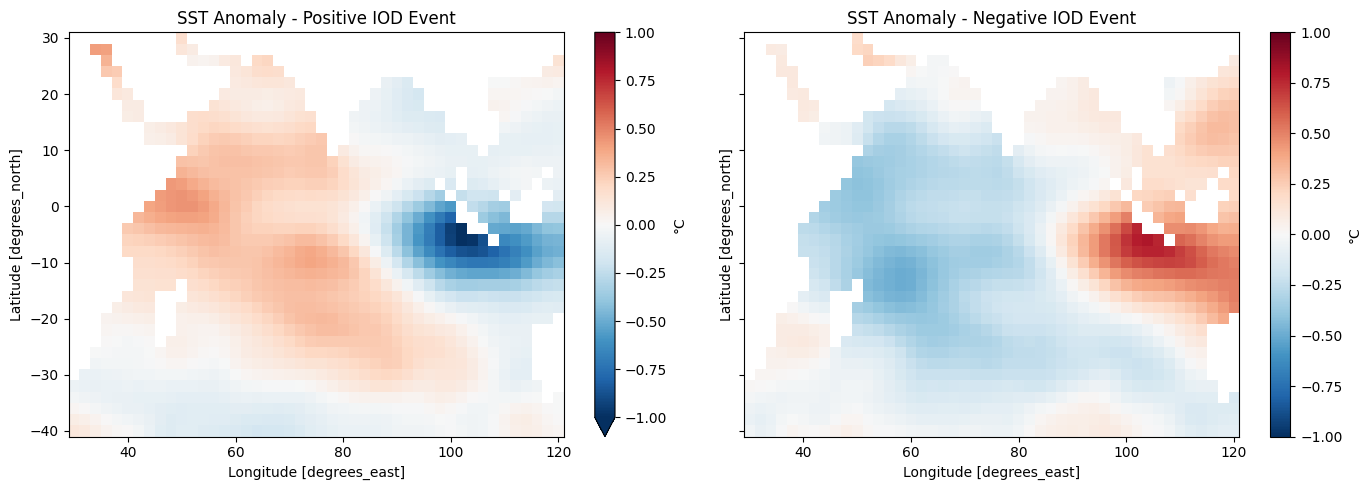

In [13]:
# Step 1: Calculate the  index using the SST anomalies
dmi_index = calculate_index(sst_anom_detrended,'dmi')

# Step 2: Calculate the SST composites for positive and negative  events
sst_anom_positive, sst_anom_negative = calculate_composites(sst_anom_detrended,dmi_index,'dmi')

# Step 3: Plot the SST composites
plot_composites(sst_anom_positive, sst_anom_negative,vmin=-1, vmax=1,lat_range=(30,-40),lon_range=(30,120), index_name='IOD')

Your ENSO Analysis here:

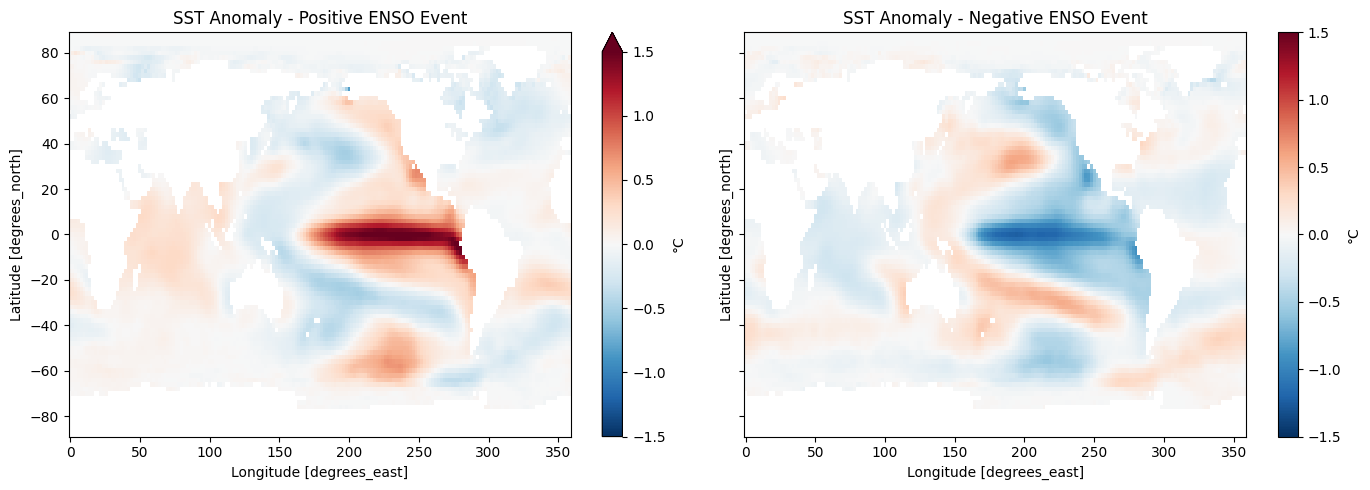

In [6]:
# basically a copy of the code cell above but modified for the nino3.4 index and no lat, lon range for the plot

# Step 1: Calculate the  index using the SST anomalies
nino_index = calculate_index(sst_anom_detrended,'nino3.4')

# Step 2: Calculate the SST composites for positive and negative  events
sst_anom_positive, sst_anom_negative = calculate_composites(sst_anom_detrended,nino_index,'nino3.4')

# Step 3: Plot the SST composites
plot_composites(sst_anom_positive, sst_anom_negative,index_name='ENSO')

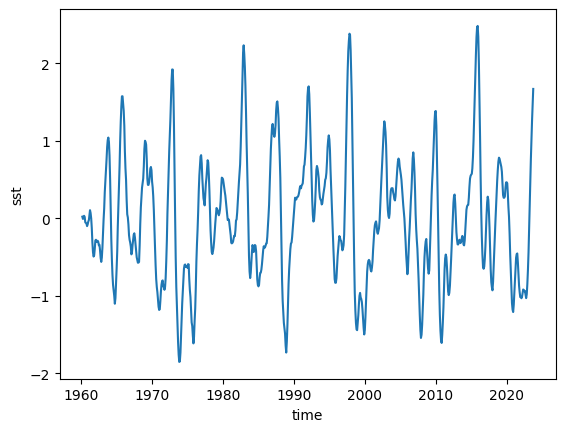

In [7]:
nino_index.plot()

In [8]:
nino_index.max()

<xarray.DataArray 'sst' ()> Size: 4B
array(2.4845095, dtype=float32)

Your TNA Analysis here:

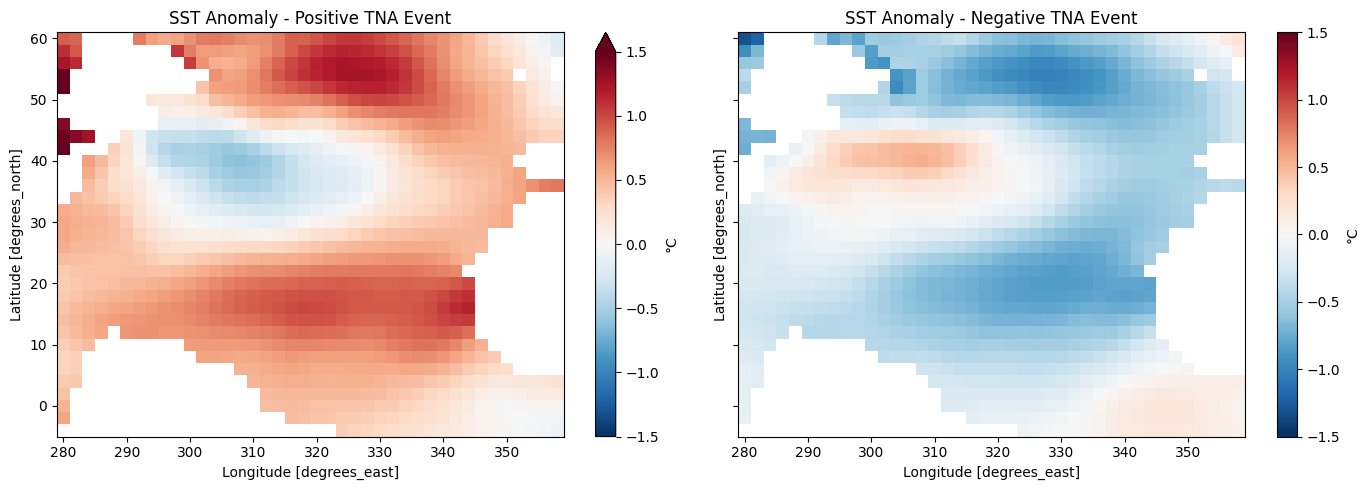

In [9]:
# basically a copy of the code cell above but modified for the tna index 


# Step 1: Calculate the  index using the SST anomalies
tna_index = calculate_index(sst_anom_detrended,'tna')

# Step 2: Calculate the SST composites for positive and negative  events
sst_anom_positive, sst_anom_negative = calculate_composites(sst_anom_detrended,tna_index,'tna')

# Step 3: Plot the SST composites
plot_composites(sst_anom_positive, sst_anom_negative,lat_range=(60,-5),lon_range=(280,360),index_name='TNA')

Your Observations:
....
#### Observations on the TNA Composite Plot

Positive TNA index (Left Plot):The positive SST anomalies are spread across much of the tropical and subtropical North Atlantic, indicating warmer-than-average sea surface temperatures in this region.
        This warming pattern can influence atmospheric circulation, potentially reducing precipitation in certain regions like Brazil and Argentina, as warm SSTs in the tropical North Atlantic are often associated with subsidence (downward air movement) in nearby areas.

Negative TNA index (Right Plot):The negative SST anomalies cover a similar area, but with cooler-than-average temperatures in the tropical North Atlantic. Such cooling in the North Atlantic can shift regional weather patterns, sometimes leading to increased rainfall in regions affected by atmospheric circulation linked to cooler Atlantic SSTs.

Further reading e.g.: [Enfield et al. (1999)](https://journals.ametsoc.org/view/journals/clim/12/7/1520-0442_1999_012_2093_tdocro_2.0.co_2.xml)  


Using June-August months for the TNA index calculation focuses the analysis on the peak of the Atlantic hurricane season, when tropical North Atlantic SSTs are most influential on regional climate patterns. Applying a 3-month rolling mean smooths out short-term fluctuations and this helps to identify broader trends. Smoothing data by applying a rolling mean makes it easier to identify consistent positive or negative events.


## Preperation Session 5 and 6:

For a general overview of how object-oriented modeling and programming work, please visit this 
[Storymap](https://storymaps.arcgis.com/stories/dd9d06f89a63400c96927de117a5b28a). The text is in German, but most browsers offer automatic translation. The article provides a closer look at the programming paradigm and dives into the benefits of encapsulation, inheritance, polymorphism, and abstraction.
